In [1]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rsmf.abstract_formatter

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Pandas configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

# Figure formatting
import rsmf
FIG_FORMATTER: rsmf.abstract_formatter.AbstractFormatter = rsmf.setup(
    r"\documentclass[a4paper,twocolumn,10pt,unpublished]{quantumarticle}"
)
COLORS = plt.get_cmap('tab10')

plt.rcParams.update({
    "axes.prop_cycle": plt.cycler("color", plt.cm.tab10.colors),
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "figure.constrained_layout.use": True,
    "figure.constrained_layout.h_pad": 0.04,
    "figure.constrained_layout.w_pad": 0.04,
    "figure.constrained_layout.hspace": 0.01,
    "figure.constrained_layout.wspace": 0.01,
    "legend.framealpha": 0.5,
})

# For in-line display of rsmf figures
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
matplotlib.use('module://matplotlib_inline.backend_inline')

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

from simulations.analysis.plotting_helpers import error_band_plot, load_data, take_best_by_from_df_ps_dict

## Generate an example circuit

In [6]:
H = np.loadtxt("../../data/hgp_prebuilt/check_matrices/n12_dv3_dc4_d6.txt")
H = H.astype("uint8")
H

array([[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
       [0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]], dtype=uint8)

In [9]:
from simulations.utils.build_random_hgp_circuits import compute_hgp_code_parameters

code, code_prms = compute_hgp_code_parameters(H, H)

print(code_prms)

(225, 9, 6)


In [11]:
from simulations.utils.build_circuit import build_BB_circuit

circuit = build_BB_circuit(n=144, T=1, p=1e-3)

In [25]:
from simulations.utils.build_random_hgp_circuits import build_hgp_circuit_from_code

dv, dc = 3, 4
n, k, d = code_prms
T = d
p = 1e-3

# Create circuit
circuit = build_hgp_circuit_from_code(
    code, p, T, noisy_init=True, noisy_meas=True, seed=22
)

In [27]:
# Save circuit
circuit_dir = "../../data/hgp_prebuilt/circuits"
circuit.to_file(os.path.join(circuit_dir, f"({dv},{dc})_n{n}_k{k}_d{d}_T{T}_p{p}.stim"))

## pfail vs pabort

In [5]:
filter = {"n": 225, "k": 9, "d": 6}
df_ps_dict = load_data("hgp", filter=filter)

In [6]:
df_ps_dict.keys()

dict_keys(['cluster_llr_norm_2', 'cluster_size_norm_gap_inf', 'cluster_llr_norm_gap_0.5', 'cluster_size_norm_inf', 'cluster_llr_norm_gap_1', 'cluster_llr_norm_0.5', 'cluster_size_norm_1', 'detector_density', 'cluster_size_norm_gap_1', 'cluster_llr_norm_1', 'cluster_llr_norm_inf', 'cluster_size_norm_0.5', 'cluster_llr_norm_gap_inf', 'cluster_size_norm_2', 'cluster_size_norm_gap_0.5', 'cluster_llr_norm_gap_2', 'pred_llr', 'cluster_size_norm_gap_2'])

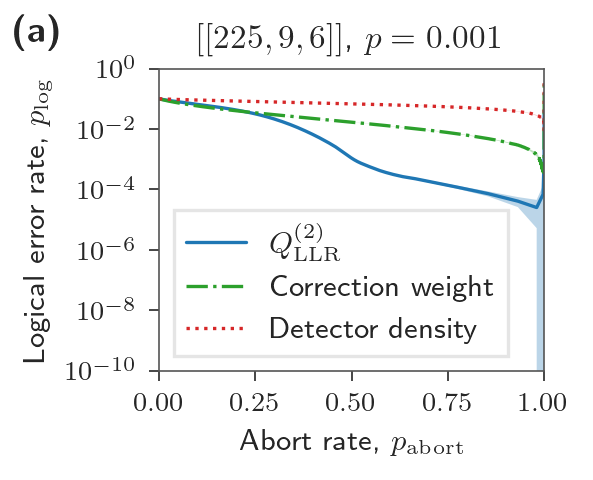

In [36]:
height = 0.28
width_ratio = 0.35
aspect_ratio = height / width_ratio
fig = FIG_FORMATTER.figure(
    wide=True, width_ratio=width_ratio, aspect_ratio=aspect_ratio
)
ax = fig.add_subplot()

prms = (225, 9, 6, 6, 1e-3)
n, k, d, T, p = prms

keys = ["cluster_llr_norm_2", "pred_llr", "detector_density"]
labels = [r"$Q_\mathrm{LLR}^{(2)}$", r"Correction weight", r"Detector density"]
colors = [COLORS(0), COLORS(2), COLORS(3)]
linestyles = ["-", "-.", ":"]

i = 0
data_plots = {}
for by in keys:
    p_abort_col = "p_abort"
    p_fail_col = "p_fail"
    delta_p_fail_col = "delta_p_fail"

    df_ps = df_ps_dict[by].loc[prms].reset_index()

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values
    delta_p_fail = df_ps[delta_p_fail_col].values
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=colors[i],
        linestyle=linestyles[i],
        label=labels[i],
        ax=ax,
    )
    i += 1

# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)
ax.set_yticks(10.0 ** np.arange(-10, 1, 2))
ax.set_title(rf"$[[{n}, {k}, {d}]]$, $p={p}$", fontsize=10)

ax.set_xlabel(r"Abort rate, $p_\mathrm{abort}$")
ax.set_ylabel(r"Logical error rate, $p_\mathrm{log}$")

fig.text(
    0,
    1,
    r"\textbf{(a)}",
    fontsize=11,
    in_layout=False,
    transform=fig.transFigure,
    verticalalignment="top",
)

fig.savefig("overleaf_figs/hgp_code_metric_comparison_plog_vs_pabort.pdf")

In [37]:
prms = (225, 9, 6, 6, 1e-3)
n, k, d, T, p = prms

# Create ordered list of keys
ordered_keys = df_ps_dict.keys()

i = 0
data_plots = {}
for by in ordered_keys:
    try:
        df_ps = df_ps_dict[by].loc[prms].reset_index()
    except KeyError:
        continue

    p_abort_col = "p_abort"
    p_fail_col = "p_fail"
    delta_p_fail_col = "delta_p_fail"

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values
    delta_p_fail = df_ps[delta_p_fail_col].values
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

0: cluster_size_norm_2 (1.06e-03 ± 2.84e-05)
1: cluster_size_norm_inf (1.09e-03 ± 2.87e-05)
2: cluster_llr_norm_2 (1.11e-03 ± 2.92e-05)
3: cluster_llr_norm_inf (1.13e-03 ± 2.94e-05)
4: cluster_size_norm_1 (1.78e-03 ± 3.68e-05)
5: cluster_llr_norm_1 (1.97e-03 ± 3.86e-05)
6: pred_llr (1.68e-02 ± 1.13e-04)
7: cluster_llr_norm_0.5 (3.99e-02 ± 1.71e-04)
8: cluster_size_norm_0.5 (4.16e-02 ± 1.75e-04)
9: detector_density (6.89e-02 ± 2.18e-04)


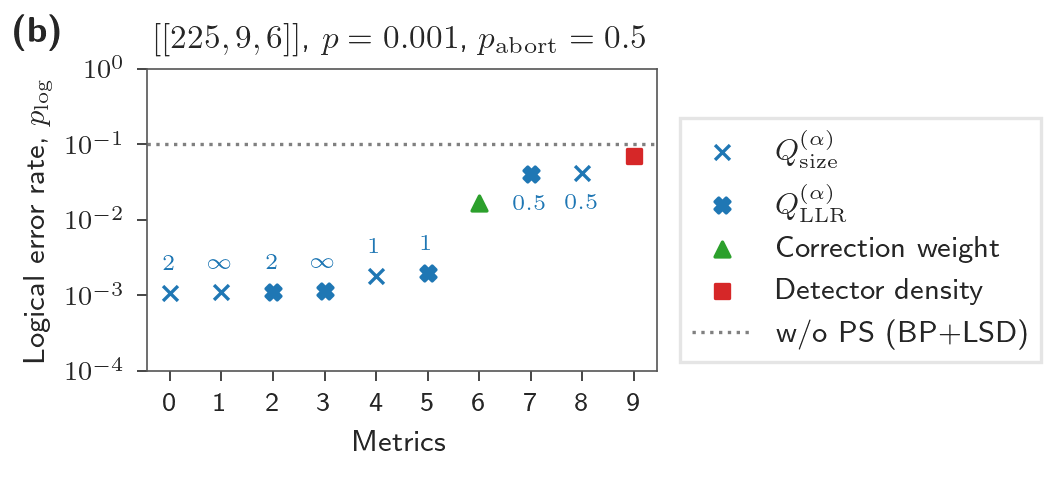

In [38]:
target = 0.5
bys, y_vals, y_errs = [], [], []

by_to_exclude = [
    "average_cluster_size",
    "average_cluster_llr",
    "matching_pred_llr",
    "matching_detector_density",
    "cluster_llr_residual_sum",
    "cluster_llr_residual_sum_gap",
]

for by, (p_abort, p_fail, delta_p_fail) in data_plots.items():
    if by in by_to_exclude:
        continue
    if "norm_gap" in by:
        continue
    ind = np.where(p_abort <= target)[0]
    if len(ind):
        sel = ind[-1]
    else:
        sel = 0
    bys.append(by)
    y_vals.append(p_fail[sel])
    y_errs.append(delta_p_fail[sel])

sort_inds = np.argsort(y_vals)
by_sorted = [bys[i] for i in sort_inds]
y_vals_sorted = [y_vals[i] for i in sort_inds]
y_errs_sorted = [y_errs[i] for i in sort_inds]

for i, by in enumerate(by_sorted):
    print(f"{i}: {by} ({y_vals_sorted[i]:.2e} ± {y_errs_sorted[i]:.2e})")


def determine_group(by):
    if "matching" in by:
        group = 2
        color = COLORS(1)
        label = "Logical gap (MWPM)"
        marker = "o"
    elif "cluster_size_norm" in by:
        group = 0
        label = r"$Q_\mathrm{size}^{(\alpha)}$"
        marker = "x"
        color = COLORS(0)
    elif "cluster_llr_norm" in by:
        group = 1
        label = r"$Q_\mathrm{LLR}^{(\alpha)}$"
        marker = "X"
        color = COLORS(0)
    elif by == "pred_llr":
        group = 3
        label = "Correction weight"
        marker = "^"
        color = COLORS(2)
    elif by == "detector_density":
        group = 4
        label = "Detector density"
        marker = "s"
        color = COLORS(3)
    else:
        group = None
        label = "other"
        marker = "s"
        color = COLORS(5)
    return group, label, marker, color


# Group data and plot with different colors
group_labels_added = set()
legend_handles = []
legend_labels = []

height = 0.28
width_ratio = 0.64
aspect_ratio = height / width_ratio
fig = FIG_FORMATTER.figure(
    wide=True, width_ratio=width_ratio, aspect_ratio=aspect_ratio
)
ax = fig.add_subplot()

for i, by in enumerate(by_sorted):
    group, group_label, marker, color = determine_group(by)
    assert group is not None
    label = group_label if group_label not in group_labels_added else None

    handle = ax.scatter(
        i,
        y_vals_sorted[i],
        marker=marker,
        s=20,
        color=color,
        label=label,
    )

    # Add number annotation for "norm" metrics
    if "norm" in by:
        norm_order = by.split("_")[-1]
        if norm_order == "inf":
            norm_order = r"$\infty$"
        else:
            norm_order = rf"${norm_order}$"

        if norm_order != rf"$0.5$":
            y_text = y_vals_sorted[i] * 1.8
        else:
            y_text = y_vals_sorted[i] * 0.3

        ax.text(
            i,
            y_text,  # Position slightly above the marker
            norm_order,
            ha="center",
            va="bottom",
            fontsize=6.5,
            color=color,
        )

    if label:
        group_labels_added.add(group_label)
        legend_handles.append((group, handle))
        legend_labels.append((group, group_label))

pfail_org = df_ps_dict["cluster_llr_norm_1"].loc[prms]["p_fail"].values[-1]

line = ax.axhline(pfail_org, color="grey", linestyle=":", label="BP+LSD")


# Sort legend by group order
legend_handles.sort(key=lambda x: x[0])
legend_labels.sort(key=lambda x: x[0])

legend_handles.append((999, line))  # Use high number to put at end
legend_labels.append((999, "w/o PS (BP+LSD)"))

ax.set_title(
    rf"$[[225, 9, 6]]$, $p = {p}$, $p_\mathrm{{abort}} = {target}$",
    fontsize=10,
)
ax.set_xticks(np.arange(len(by_sorted)))
ax.set_xticklabels(np.arange(len(by_sorted)))
ax.set_xlabel("Metrics")
ax.set_ylabel(r"Logical error rate, $p_\mathrm{log}$")
ax.set_yscale("log")
ax.set_ylim(1e-4, 1)
# ax.set_yticks(10.0 ** np.arange(-4, 1, 1))

fig.legend(
    [h[1] for h in legend_handles],
    [l[1] for l in legend_labels],
    loc="outside right",
)

fig.text(
    0,
    1,
    r"\textbf{(b)}",
    fontsize=11,
    in_layout=False,
    transform=fig.transFigure,
    verticalalignment="top",
)

plt.savefig("overleaf_figs/hgp_code_metric_comparison.pdf")